# Spine Model


In [1]:
from numpy import *   #ones, cumsum, sum, isscalar
from matplotlib.pylab import * 
%matplotlib inline
plotose = True
import pickle

import PS_lib as lb
import PS_storage as st
import PS_tools as tools

from bootstrap_unshr import btset_cd, generateplots, btShInh, btShInhwpos
from data_Fullset import SCxL23 as exppar

# Parameter definitions
# Data is stored here      
data = st.dataStorage() # some default parameters defined.
data.dt = 0.05
data.NMDA = False

# Definition of the model.
lb.h.dt = data.dt
NMDA = data.NMDA
model = lb.loadNeuron("ball-2sticks.hoc",axon=False)

# Adding piece of dendritic branch with spine
model.addDend(name="dendShaft",locus="dendA1",L=4.0,D=1.5,ilocus=1)
model.addSpne(locus="dendShaft",ilocus=0.5,L=1.0,D=1.0,Lneck=1.0,Dneck=0.15)
# Temperature of the neuron
lb.h.celsius = model.temperature
model.addDend(name="dendA2",locus=3,L=10.0,D=0.5,ilocus=1)
data.model = model.__dict__

model.soma.L = 20
#model.comp['B1'].L = 200
#model.comp['B1'].diam = 10
print(model.soma.L,model.soma.diam,model.soma(0.5).area(),model.dend[-1](0.5).area())

print("Topology:")
print(lb.h.topology())



	0 
	1 
	1 
	1 
	1 
20.0 29.78380012512207 1871.3713533814052 15.707963267948966
Topology:

|-|       soma(0-1)
   `|       dendA1prox(0-1)
     `|       dendA1(0-1)
       `|       dendShaft(0-1)
         `|       dendA2(0-1)
        `|       NSpne000(0-1)
          `|       Spne000(0-1)
   `|       dendB1(0-1)

1.0


### Bootstrapping spines and synapses



In [2]:
nsp = 500
dis = btset_cd(cd='DiS',size=nsp)
sis = btset_cd(cd='SiS',size=nsp)
sps = btset_cd(cd='Sp',size=nsp)

dis['Rneck'] = dis['Rneck']#*2
sis['Rneck'] = sis['Rneck']#*2
sps['Rneck'] = sps['Rneck']#*2

iPSDsh = btShInh(size=nsp)


sp = model.spne[0]
sp.L = dis["L"].mean()
sp.diam = dis["D"].mean()

print("Area Volume Ah Vh")
print(sp(0.5).area(),sp(0.5).volume(),dis["Ah"][0]/dis["AhA0"][0],dis["Vh"][0])

Area Volume Ah Vh
0.942590509110137 0.13718343488370136 1.8483826496677291 0.3762686131931453


In [3]:
gtrG = exppar.gtrG
gtrA = exppar.gtrA
gtrN = exppar.gtrN


### Excitatory synapse 

We need to define the arrival time and dynamics. These parameters may be modified later

In [4]:
model.AMPAlist = []
model.ncAMPAlist = []

AMPA = lb.h.Exp2Syn(1,sec = model.spne[0])
tau1  = exppar.AMPAtaus[0]
tau2 = exppar.AMPAtaus[1]
AMPA.tau1 = tau1
AMPA.tau2 = tau2

gmax = gtrA*sps['A1'].mean()
stimE=lb.h.NetStim();stimE.number = 1; 
NC = lb.h.NetCon(stimE,AMPA,0,0,gmax)

model.AMPAlist.append(AMPA)
model.ncAMPAlist.append(NC)
NC.delay = 10

# NMDA part
gmaxN = gtrN*sps['A1'].mean()
lb.add_NMDAsyns(model, locs=[[0,0.5]], gmax=gmaxN,tau2=20.0)  
NMDA = model.NMDAlist[0]
NCN = model.ncNMDAlist[0]
stimN=lb.h.NetStim();stimN.number = 1;
NCN = lb.h.NetCon(stimN,NMDA,0,0,gmaxN)
model.ncNMDAlist[0] = NCN
NMDA.tau1 = exppar.NMDAtaus[0]
NMDA.tau2 = exppar.NMDAtaus[1]

### Inhibitory synapse

In [5]:
gmaxG = gtrG*dis['A2'].mean()
GABA, NCG = lb.add_GABAsyns(model, locs=[[0,1]], spne=True, gmax=gmaxG,tau1=exppar.GABAtaus[0],tau2=exppar.GABAtaus[1])  


inhOutside = exppar.inhOutside
if inhOutside:
    gmaxG = gtrG*iPSDsh.mean()
    GABA2, NCG2 = lb.add_GABAsynscomp(model, model.comp['dendShaft'], loc = 0.1, gmax=gmaxG,tau1=exppar.GABAtaus[0],tau2=exppar.GABAtaus[1])  


# Recordings

In [6]:
trec, vrec = lb.h.Vector(), lb.h.Vector()
gRec, iRec,  vspneRec = [], [], []
gNMDA_rec, iNMDA_rec = [], []
trec.record(lb.h._ref_t)
vrec.record(model.soma(0.5)._ref_v)


#n=0
vDendRec = []
vRecn = {}
#For all dendrites
for dend in model.dend:
    #Adding vectors for Voltage, and Calcium
    vDendRec.append(lb.h.Vector())
    # Placing recording at mid-point in the dendritic branch
    vDendRec[-1].record(dend(0.5)._ref_v)
    vRecn[dend.name()] = vDendRec[-1]
    # NO CALCIUM!?!?!
#Probably better to organize them in a dictionary        
vDendRec[1].record(model.dend[1](1.0)._ref_v)

# Spine voltage recording stuff
vspneRec.append(lb.h.Vector())
vspneRec.append(lb.h.Vector())
sp = model.spne[0]
vspneRec[0].record(sp(0.5)._ref_v)
sp = model.neck[0]
vspneRec[1].record(sp(0.5)._ref_v)

# Calcim

caDendRec = []
caRecn = {}
sp = model.spne[0]
caDendRec.append(lb.h.Vector())
caDendRec.append(lb.h.Vector())
caDendRec.append(lb.h.Vector())
caDendRec[0].record(sp(0.5)._ref_ica) 
caDendRec[1].record(model.NMDAlist[0]._ref_i)
caDendRec[2].record(sp(1.0)._ref_cai) 
caRecn['sp ica'] = caDendRec[0]
caRecn['sp iNMDA'] = caDendRec[1]
caRecn['sp Ca'] = caDendRec[2]


In [7]:
vDendEL = []
dend = model.dend[1]
for i in range(10):
    vDendEL.append(lb.h.Vector())
    vDendEL[-1].record(dend((i+1.0)/10.0)._ref_v)

In [8]:
vDendEL2 = []
dend = model.dend[-1]
for i in range(10):
    vDendEL2.append(lb.h.Vector())
    vDendEL2[-1].record(dend((i+1.0)/10.0)._ref_v)

In [9]:
iRec.append(lb.h.Vector())
iRec.append(lb.h.Vector())
currentAMPA = iRec[0]

currentGABA = iRec[1]
iRec.append(lb.h.Vector())
currentNMDA = iRec[-1]
currentNMDA.record(NMDA._ref_i)


Vector[34]

In [10]:
currentAMPA.record(AMPA._ref_i)
currentGABA.record(GABA._ref_i)

Vector[33]

In [11]:
iRec.append(lb.h.Vector())
currentGABA2 = iRec[-1]
currentGABA2.record(GABA2._ref_i)


Vector[35]

## Small tuning parameters for dendrite?

In [12]:
dendsizeL0 = exppar.dendsizeL0
dendsizeL = max(max(max(dis['Dss'])+5,max(sis['Dss'])+5),150)
neck = model.neck[0]
Rneck = neck.L*1e-6/(neck.diam*1e-6/2.0)**2/pi*neck.Ra/100
dend = model.comp['dendA1prox']
dend.L = exppar.dendsizeL0
dend.diam = exppar.denddiam0

In [13]:
dendA2 = model.comp['dendA2']
dendA1 = model.comp['dendA1']
dendsh = model.comp['dendShaft']

dendA2.L = 1.0

In [14]:
dendsh.diam = exppar.dendDiam
dendA1.diam = exppar.dendDiam
dendA2.diam = exppar.dendDiam   

In [15]:
model.RM = exppar.rm
for sec in lb.h.allsec():
    sec.Ra = exppar.ra
    sec.cm = 1.0
    sec.g_pas = 1.0/model.RM

factor = exppar.factor2nddend
model.comp['dendB1'].cm = factor
model.comp['dendB1'].g_pas = factor/model.RM
model.comp['dendB1'].L = exppar.len2nddend
model.comp['dendB1'].diam = 1

In [16]:
rhosp = 1.3
diamneck = sps['meanDneck'].mean()/1e3
dendareaperL = rhosp*(mean(sps['Ah'])+(pi*diamneck))
factor = dendareaperL/(pi*dendA1.diam)
print(factor)
factorsp = factor
factordd = (pi*dendA1.diam-(pi*diamneck**2/4.0)*rhosp)/(pi*dendA1.diam)
print(factordd,factordd+factorsp)

factor = factordd+factorsp
factor = exppar.factorspinesdend
dendA2.cm = factor
dendA1.cm = factor

dendA2.g_pas = factor/model.RM
dendA1.g_pas = factor/model.RM

1.9061368649374475
0.9769921513618588 2.883129016299306


In [17]:
dendA1.nseg = int(dendA1.L//10)+1
dendA2.nseg = int(dendA2.L//10)+1

dendA1.nseg = 10
dendA2.nseg = 10
print(dendA1.nseg,dendA2.nseg)

10 10


In [18]:
lb.init_active(model, axon=False, soma=False, dend=False, dendNa=False,
                dendCa=False,spne=True)

In [19]:
diam0 = 0.15
#Rneck0 = Rneck/1e6
#Cm0 = model.CM


In [20]:
Rneck0 = neck.Ra*sps['Lneck']/(diam0)**2*0.04/pi
#print(Rneck0,data[i,3])
#diams = diam0*sqrt(Rneck0/sps['Rneck'])
#hist(diams, 51,density = True)
#hist(sps['minDneck']/1e3,51,alpha=0.7,density = True)
#hist(sps['meanDneck']/1e3,51,alpha=0.7,density = True)

In [21]:
Rdendprox = model.comp['dendA1prox'].L*1e-6/2.0*model.comp['dendA1prox'].Ra/100/(pi*(model.comp['dendA1prox'].diam*1e-6/2.0)**2)
diam0 = 0.15

def simulateSet(model,spn,tG = 500,ton = 50,
                toffset = 50,t_stop = 250, EL = -65,
                btsr = None,VDCC = array([0.,0,0,0]), 
                dendrec = True,inhOutside= False, iPSDsh = None):
    if btsr is None:
        btsr = ones(9)==0
    model.E_PAS = EL
    model.soma.e_pas = model.E_PAS
    for dendp in model.dend:
        dendp.e_pas = model.E_PAS
    for sp in model.spne:
        sp.e_pas = model.E_PAS

    dendsh = model.comp['dendShaft']
    dendA1 = model.comp['dendA1']
    dendA2 = model.comp['dendA2']
    neck = model.neck[0]
    sp = model.spne[0]

    dshL = dendsh.L
    dendsizeL = dendsh.L+dendA1.L+dendA2.L
    data = column_stack((spn["A1"],spn["A1"],spn["A2"],spn["Rneck"],spn["Dss"],spn["L"],spn["D"],spn["Ln"],spn["AhA0"], spn["meanDneck"]/1e3))
    if isnan(data).sum()>0:
        raise "There are nans do something about it"
    for i in range(9):
        if ~btsr[i]:
            data[:,i] = data[:,i].mean()
         
    nsp = data.shape[0]
    if iPSDsh is None:
        iPSDsh = zeros(nsp)
    mes = zeros((nsp,9))
    me2 = zeros((nsp,11))
    me3 = zeros((nsp,10))

    iad = 2
    vavg = zeros((int(t_stop/lb.h.dt)+iad,7))
    vtracs = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    Ctracs = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    vtracsD = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    vtracsS = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    for i in arange(nsp):
        NC.weight[0]  = data[i,0] *gtrA#/2
        NCN.weight[0] = data[i,1] *gtrN#*0#*0
        NCG.weight[0] = data[i,2] *gtrG#*0
        NCG2.weight[0] = iPSDsh[i] *gtrG#*0

        # print(NCG2.weight[0], iPSDsh[i],gtrG,i)
        if inhOutside:
            NCG.weight[0] = 0.0
        else:
            NCG2.weight[0] = 0.0
            
            
        neck.L = data[i,7]  
        Rneck0 = neck.Ra*neck.L/(diam0)**2*0.04/pi
        #print(Rneck0,data[i,3])
        neck.diam = diam0*sqrt(Rneck0/data[i,3])
        
        # neck.diam = data[i,9]
        # Rneck = neck.Ra*neck.L/(neck.diam)**2*0.04/pi
        # neck.Ra = data[i,3]*(neck.diam)**2*pi/0.04/neck.L
        
        posD = data[i,4]
        
        dendA1.L = posD-dshL/2
        dendA2.L = dendsizeL-posD-dshL/2

        # print(NCG.weight[0],NCG2.weight[0])
        # A = pi*D**2
        sp.L = data[i,5]
        sp.diam = data[i,6]
        sp.cm = data[i,8]
        sp.g_pas = data[i,8]/model.RM
        spvol = sp(0.5).volume()
        spineArea =  sp(0.5).area()#sp.L*sp.diam+1.8*sp.diam**2/4 # um^2
        
        CaTcond = 1e-3# pS
        sp.pbar_caL13PS = VDCC[0]*CaTcond#/spineArea
        sp.pbar_caLPS = VDCC[1]*CaTcond#/spineArea
        sp.pbar_canPS = VDCC[2]*CaTcond#/spineArea
        sp.pcaqbar_caqPS = VDCC[3]*CaTcond#/spineArea
        
        
        NC.delay = toffset+ton-50
        NCN.delay = toffset+ton-50
        NCG.delay = toffset+tG#toffset+tG#-50
        NCG2.delay = toffset+tG#toffset+tG#-50

        for il in range(10):
            f = 1-7.5*il/dendA1.L
            #f = 0.5
            if f>=0:
                vDendEL[il].record(dendA1(f)._ref_v)
            else:
                vDendEL[il].record(dendA1(0.0)._ref_v)
        
        for il in range(10):
            f = 7.5*il/dendA2.L
            #f = 0.5
            if f<=1:
                vDendEL2[il].record(dendA2(f)._ref_v)
            else:
                vDendEL2[il].record(dendA2(1.0)._ref_v)
                
        lb.h.finitialize(model.E_PAS)
        
                    
        lb.neuron.run(t_stop)
        
        
        current = abs((array(vDendRec[0])-array(vrec[0]))/Rdendprox)
        
        vtracs[:,i] = array(vspneRec[0]) 
        if dendrec:
            vtracsD[:,i] = array(vDendRec[1])
        else:
            vtracsD[:,i] = array(vDendEL[2])
            
        vtracsS[:,i] = array(vrec) 

        vavg[:,0] += array(vspneRec[0]) 
        vavg[:,1] += array(vspneRec[0])**2
        vavg[:,2] += array(vDendRec[1]) 
        vavg[:,3] += array(vDendRec[1])**2
        vavg[:,4] += array(vrec) 
        vavg[:,5] += array(vrec)**2
        vavg[:,6] += 1
            
        cat = array(caDendRec[-1])/1e-3
        Ctracs[:,i] = cat-cat[0] 
        if inhOutside:
            aG = abs(array(currentGABA2)).argmax()
            maxGABA = array(currentGABA2)[aG]
        else:
            aG = abs(array(currentGABA)).argmax()
            maxGABA = array(currentGABA)[aG]

            
        #aG = abs(array(currentGABA)).argmax()
        aA = abs(array(currentAMPA)).argmax()
        aN = abs(array(currentNMDA)).argmax()
        
        mes[i,:] = [data[i,3],max(vspneRec[0])-EL,
                    max(vDendRec[3])-EL,max(vrec)-EL,
                    max(cat)-cat[0],maxGABA,
                    array(currentAMPA)[aA],max(abs(current)),
                    array(currentNMDA)[aN]]
        me2[i,0] = max(vDendRec[3])
        me2[i,1:] = [max(vD) for vD in vDendEL]
        me3[i,:] = [max(vD) for vD in vDendEL2]

        #plot(trec,array(caDendRec[-1])/1e-3)
        #ylabel("[Ca] (uM)")
        #figure()
        #plot(trec,vspneRec[0])
        #break
        
    vavg[:,:5] = vavg[:,:5]/vavg[0,6]
    vavg[:,1] = sqrt(vavg[:,1]-vavg[:,0]**2)#/sqrt(vavg[0,6])
    vavg[:,3] = sqrt(vavg[:,3]-vavg[:,2]**2)#/sqrt(vavg[0,6])
    vavg[:,5] = sqrt(vavg[:,5]-vavg[:,4]**2)#/sqrt(vavg[0,6])
    return(vavg,mes,vtracs,vtracsD,vtracsS,
           Ctracs,me2,me3,array(trec))

In [22]:
VDCCa =  array([0.04023183, 0.08000483, 0.03416801, 0.02747762] )
EL0 = -70

In [23]:
#vavg0,mes0,vtracs0,vtracsD0,vtracsS0,Ctracs0,me20,me30, trec = simulateSet(model,dis,tG = 100,ton = 50,toffset = 100,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa, dendrec=False)
#plot(arange(vtracs0.shape[0])*lb.h.dt,vtracs0[:,0])

In [24]:
from PS_tools import *

In [25]:
from bootstrap_unshr import dataset,datasetfile
with open(datasetfile,"rb") as f:
    data = pickle.load(f)
spdata = dataset(data,noise=0.0)
print(spdata['A1'].shape)
spdata['A2'][isnan(spdata['A2'])] = 0.0
#spdata['Rneck'] = spdata['Rneck']
print(spdata['A2'].shape)

sel = ones(spdata['A2'].shape[0]) == 1
keys = list(spdata.keys())
print(keys)
keys.pop(12)
keys.pop(11)
keys.pop(7)
keys.pop(3)
keys.pop(9)
keys.pop(3)
print(keys)

for key in keys:
    sel = sel*isfinite(spdata[key])
    print(key, isfinite(spdata[key]).sum())
for key in spdata.keys():
    spdata[key] = spdata[key][sel]
    #print(key,':',isfinite(spdata[key]).sum())
dendsizeL = max(max(spdata['Dss'])+5,150)
print(spdata['A1'].shape)

(390,)
(390,)
['#Sp', '#Bch', 'Dsb', 'Dss', 'd_interSp', 'Vtot', 'Vh', 'Ln', 'SA', 'nPSD', 'A1', 'A2', 'GPHN_SNR', 'DiS-EMchk', 'Lneck', 'maxDneck', 'minDneck', 'meanDneck', 'Rneck', 'Lhead', 'maxDhead', 'minDhead', 'meanDhead', 'Ah', 'Rhead', 'meanDneck_trunc70pc', 'L', 'D', 'AhA0']
['#Sp', '#Bch', 'Dsb', 'Vtot', 'Vh', 'SA', 'nPSD', 'A1', 'Lneck', 'maxDneck', 'minDneck', 'meanDneck', 'Rneck', 'Lhead', 'maxDhead', 'minDhead', 'meanDhead', 'Ah', 'Rhead', 'meanDneck_trunc70pc', 'L', 'D', 'AhA0']
#Sp 390
#Bch 390
Dsb 390
Vtot 389
Vh 389
SA 390
nPSD 390
A1 384
Lneck 390
maxDneck 390
minDneck 390
meanDneck 390
Rneck 390
Lhead 390
maxDhead 390
minDhead 390
meanDhead 390
Ah 390
Rhead 390
meanDneck_trunc70pc 390
L 390
D 389
AhA0 389
(384,)


/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [26]:
spdata['A1'].shape

(384,)

In [27]:
gtrA0 = gtrA

In [28]:
#model.RM = 15e3
#AMPA.tau1 = 0.10
#AMPA.tau2 = 0.7
print(model.RM,AMPA.tau1,AMPA.tau2)

12000.0 0.1 1.8


In [29]:
dendA2 = model.comp['dendA2']
dendA1 = model.comp['dendA1']

In [30]:
#gtrA = gtrA0*49.5/49
#for sec in lb.h.allsec():
#    sec.Ra = 250
#    sec.cm = 1.0
#    sec.g_pas = 1.0/model.RM
#
#factor = 1
#model.comp['dendB1'].cm = factor
#model.comp['dendB1'].g_pas = factor/model.RM
#model.comp['dendB1'].L = 30
#model.comp['dendB1'].diam = 1
#
#extra = 3.7
#dendA2.cm = extra
#dendA1.cm = extra
#
#dendA2.g_pas = extra/model.RM
#dendA1.g_pas = extra/model.RM

In [31]:
td = 500
res = simulateSet(model,spdata,tG = td,ton = 50,
                  toffset = 70,t_stop = 500, 
                  EL = EL0,btsr = ones(9)==1,VDCC = VDCCa,
                  dendrec=False)
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = res
#with open("../SpineModel/All_baseline_datasetx2.pickle","wb") as f:
#    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,spdata],f) 
 

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in sqrt


Spines <uEPSC> = 21.11, (med,cf int 0.68) = (14.84,5.75,40.24)
DiS <uEPSC> = 32.87, (med,cf int 0.68) = (28.91,14.28,57.16)
<uEPSP> = 0.36, (med,cf int 0.68) = (0.25,0.09,0.64)
CV and conductance 0.9392464644090328 0.3217109765003188


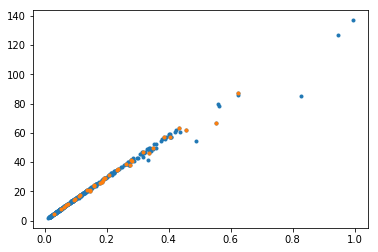

In [32]:
plot(spdata['A1'],-mes[:,-3]*1000,'.')
sel = spdata['nPSD']==2.0
plot(spdata['A1'][sel],-mes[sel,-3]*1000,'.')
i = getintp(-mes[:,-3]*1000,0.68)
print('Spines <uEPSC> = %.2f, (med,cf int 0.68) = (%.2f,%.2f,%.2f)' % (-mes[:,-3].mean()*1e3,i[0],i[1],i[2]))
i = getintp(-mes[sel,-3]*1000,0.68)
print('DiS <uEPSC> = %.2f, (med,cf int 0.68) = (%.2f,%.2f,%.2f)' % (-mes[sel,-3].mean()*1e3,i[0],i[1],i[2]))

i = getintp(mes[:,3],0.68)
print('<uEPSP> = %.2f, (med,cf int 0.68) = (%.2f,%.2f,%.2f)' % (mes[:,3].mean(),i[0],i[1],i[2]))
print('CV and conductance', mes[:,3].std()/mes[:,3].mean(), spdata['A1'].mean()*gtrA*1e3)

In [33]:
spdata['A1'].shape

(384,)

In [34]:
print('CV spine, dend, soma', mes[:,1].std()/mes[:,1].mean(),mes[:,2].std()/mes[:,2].mean(),mes[:,3].std()/mes[:,3].mean())

CV spine, dend, soma 0.9479675277601505 0.9041482959042451 0.9392464644090328


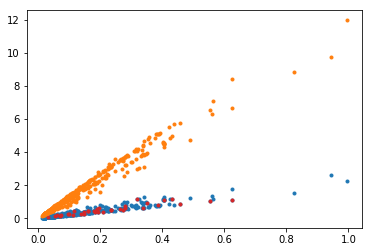

In [35]:
plot(spdata['A1'],mes[:,3],'.')
plot(spdata['A1'][sel],mes[sel,3],'C3.')
plot(spdata['A1'],me2[:,2]+70,'.')
#plot(spdata['A1'],vtracsD.max(0)+70,'.')


(118, 140)

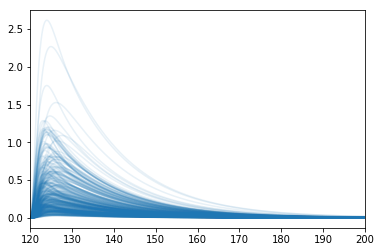

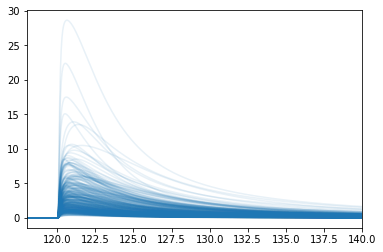

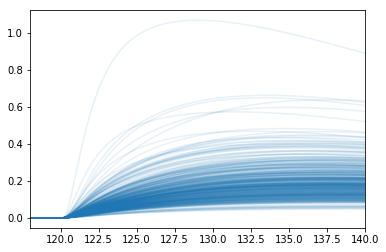

In [36]:
trec = 0.05*arange(vtracsS.shape[0])
for i in range(vtracsS.shape[1]):
    plot(trec,vtracsS[:,i]+70,'C0',alpha=0.1)
xlim(2400*.05,4000*.05)

figure()
trec = 0.05*arange(vtracsS.shape[0])
for i in range(vtracsS.shape[1]):
    plot(trec,vtracs[:,i]+70,'C0',alpha=0.1)
xlim(118,140)

figure()
trec = 0.05*arange(vtracsS.shape[0])
for i in range(vtracsS.shape[1]):
    plot(trec,Ctracs[:,i],'C0',alpha=0.1)
xlim(118,140)

Soma: trise, tdecay =  1.7010416666666668 14.758413351552212


(1.7010416666666668, 14.758413351552212, 12.8821542388008, 3.3366368544865157)

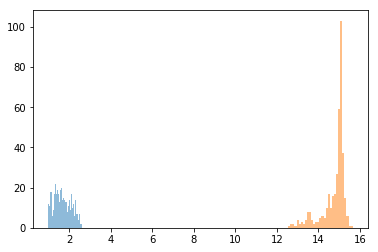

In [37]:
tFWHM = tools.get_FWHMtimes(vtracsS,-70)
ts,_,trise = tools.get_atimes(vtracsS+70,ton=2400)
tssp,_,_ = tools.get_atimes(vtracs+70,ton=2400)
#ts,_,trise = get_atimes(vtracsS+70,ton=2400)
t2080 = tools.get_p0p1times(vtracsS)#
t8020 = get_postp0p1times(vtracsS)#

#print(ts)
#h0 = hist(tFWHM,31)
#h1 = hist(ts[:,0],31,alpha=0.5)
h1 = hist(t2080,31,alpha=0.5)
h1 = hist(t8020/log(4),31,alpha=0.5)

print('Soma: trise, tdecay = ',t2080.mean(),t8020.mean()/log(4))
t2080.mean(),t8020.mean()/log(4),ts[:,0].mean(),tssp.mean()

In [38]:
t2080sp = tools.get_p0p1times(vtracs)#
t8020sp = get_postp0p1times(vtracs)#

print('Spine: trise, tdecay = ',t2080.mean(),t8020.mean()/log(4))

Spine: trise, tdecay =  1.7010416666666668 14.758413351552212


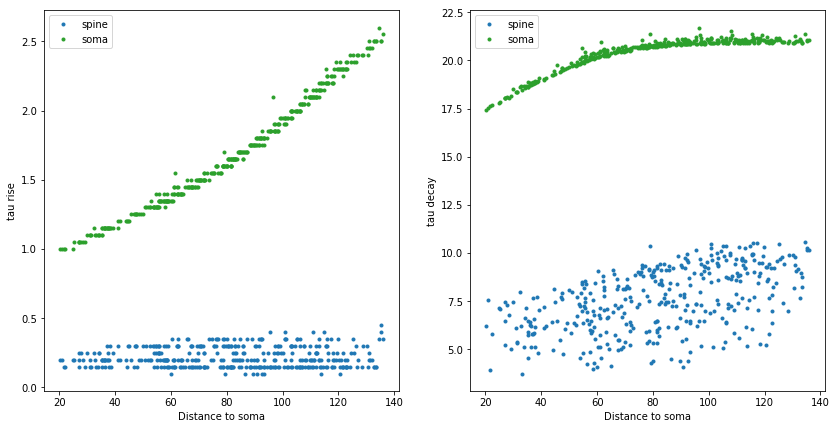

In [39]:
fig,ax = subplots(1,2,figsize=(14,7))
ax[0].plot(spdata['Dss'],t2080sp,'.',label='spine')
ax[0].plot(spdata['Dss'],t2080,'C2.',label='soma')
ax[0].set_ylabel('tau rise')
ax[0].set_xlabel('Distance to soma')
ax[0].legend()
ax[1].plot(spdata['Dss'],t8020sp,'.',label='spine')
ax[1].plot(spdata['Dss'],t8020,'C2.',label='soma')
ax[1].set_ylabel('tau decay')
ax[1].set_xlabel('Distance to soma')
ax[1].legend()

1.6203004285663198


Text(0.5, 0, 'Rneck')

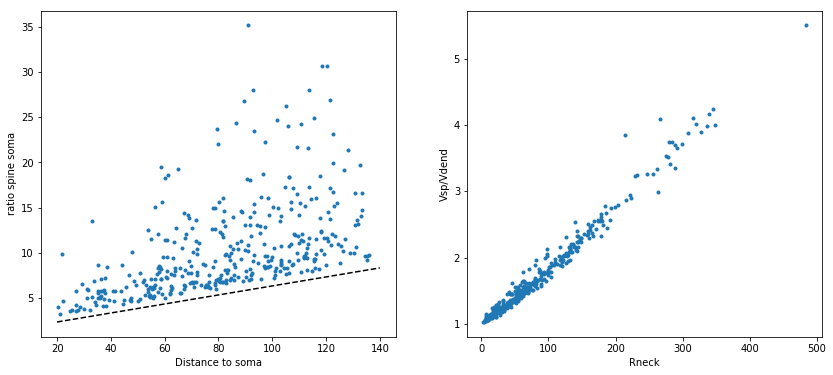

In [40]:
fig,ax = subplots(1,2,figsize=(14,6))
ax[0].plot(spdata['Dss'],mes[:,1]/mes[:,3],'.',label='spine')
ax[0].set_ylabel('ratio spine soma')
ax[0].set_xlabel('Distance to soma')
xs = linspace(20,140)
ax[0].plot(xs,xs*.05+1.3,'k--')

#ax[1].plot(spdata['Rneck'],mes[:,1]/mes[:,2],'.',label='spine')
ax[1].plot(spdata['Rneck'],(mes[:,1])/mes[:,2],'.',label='spine')
#ax[1].plot(exp((log(spdata['Rneck'])).mean()),exp((log((mes[:,1])/mes[:,2])).mean()),'ro',label='spine')

print(exp((log((mes[:,1])/mes[:,2])).mean()))
ax[1].set_ylabel('Vsp/Vdend')
ax[1].set_xlabel('Rneck')
#xs = linspace(20,140)
#ax[1].plot(xs,xs*.05+1.3,'k--')

In [41]:
1.75918/.22452, 15.676/6.040149

(7.835293069659718, 2.595300215276146)

In [42]:
#NMDA.tau1 = .5
#NMDA.tau2 = 17
print(NMDA.tau1,NMDA.tau2)

0.5 17.0


In [43]:
gtrN0 = gtrN
gtrA0 = gtrA

In [44]:
gtrA = gtrA0*0
#gtrN = rhNMDAR*30e-6*10.23975
td = 500
res = simulateSet(model,spdata,tG = td,ton = 50,toffset = 70,
                  t_stop = 500, EL = 34,btsr = ones(9)==1,
                  VDCC = VDCCa*0,dendrec=False)
vavg0,mes0,vtracs0,vtracsD,vtracsS,Ctracs,me2,me3,_ = res
print(mes[:,-2].mean())
gtrA = gtrA0

3.768173926324302e-08


In [45]:
gtrA = gtrA0

In [46]:
spdata['A1'].mean()*gtrN,spdata['A1'].mean()*gtrA

(0.00037120494288862187, 0.0003217109765003188)

In [47]:
gtrA = gtrA0
gtrN = gtrN0*0
td = 500
res = simulateSet(model,spdata,tG = td,ton = 50,toffset = 70,
                  t_stop = 500, EL = -70,btsr = ones(9)==1,
                  VDCC = VDCCa*0,dendrec=False)
vavg0,mes0,vtracs0,vtracsD,vtracsS,Ctracs,me2,me3,_ = res
gtrA = gtrA0
gtrN = gtrN0

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in sqrt


In [51]:
gtrA = gtrA0
gtrN = gtrN0*2
td = 500
res = simulateSet(model,spdata,tG = td,ton = 50,toffset = 70,
                  t_stop = 500, EL = -70,btsr = ones(9)==1,
                  VDCC = VDCCa*0,dendrec=False)
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = res

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in sqrt


In [52]:
ratio = ((mes[:,-1]+mes[:,-3])/mes0[:,-3]-1)
nanmean(ratio)

0.05623532106143278

0.07294190277122725 0.05623532106143278 0.4013550692038601


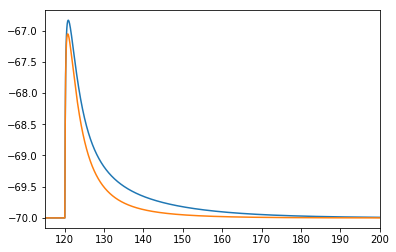

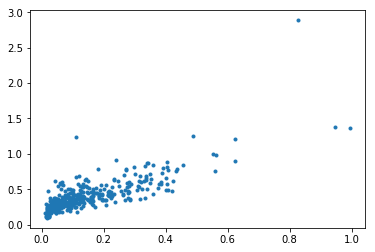

In [55]:
plot(arange(vtracs.shape[0])*0.05,vtracs.mean(1),'-')
plot(arange(vtracs.shape[0])*0.05,vtracs0.mean(1),'-')
xlim(115,200)
figure()
plot(spdata['A1'],mes[:,4],'.')
print(mes[:,1].mean()/mes0[:,1].mean()-1.0,((mes[:,-1]+mes[:,-3])/mes0[:,-3]-1).mean(),mes[:,4].mean())

In [54]:
gtrN

0.005128728

In [51]:
#GABA.tau1 = 0.5
#AMPA.tau2 = 1.3
print(GABA.tau1,GABA.tau2)

0.5 15.0


In [52]:
gtrG0 = gtrG

In [53]:
from bootstrap import  btShInhwpos

In [54]:
iPSDsh, posish = btShInhwpos(size=len(spdata['A1']))


In [55]:
Rn0 = spdata['Rneck']
A20 = spdata['A2']
Dss0 = spdata['Dss']

In [56]:
posish

shPSD_ID
180626RR3_2_PSDsh11             92.723131
180626RR1_2_PSDsh1              48.047699
180618Mmoz6_2-2_17             130.895291
180626Rmoz-fork_1-1_shPSD2      23.741293
180626Rmoz-fork_2_shPSD14       40.821214
180618Mmoz3_2-2_shPSDB          68.315230
180626Rmoz-fork_2_shPSD13       35.772179
180618Mmoz4_2_7                 89.039854
180609DDT5_1_ShaftPSD7         103.033912
180626RR3_1_PSDsh9              90.147166
180618Mmoz6_1_14bis            111.740807
180618Mmoz5_1_8                 78.637898
180618Mmoz5_2_14               117.642486
180618Mmoz6_1_14               116.081274
180609DDT5_1_ShaftPSD3          87.840471
180609DDT5_1_ShaftPSD2          91.452829
180626RR3_1_PSDsh7              68.763834
180626Rmoz-fork_1-3_shPSD12     34.513308
180609DDT5_1_ShaftPSD4          99.347004
180618Mmoz4_2_5                 81.692424
180618Mmoz6_1_15               132.358676
180626Rmoz-fork_1-2_shPSD6      34.746584
180626RR4_2_PSDsh16            112.935517
180618Mmoz5_1_11         

In [57]:
gtrA = 0.0
gtrN = 0.0
gtrG = gtrG0
#spdata['Rneck'] = Rn0*1e-3
#spdata['A2'] = A20*1.87
spdata['Dss'] = posish

res = simulateSet(model,spdata,tG = 10,ton = 50,toffset = 70,
                  t_stop = 500, EL = 8.0,btsr = ones(9)==1,
                  VDCC = VDCCa,dendrec=False,inhOutside = True, iPSDsh=iPSDsh)

vavg1,mes1,vtracs1,vtracsD1,vtracsS1,Ctracs1,me2,me3,_ = res
gtrA = gtrA0
gtrN = gtrN0
gtrG = gtrG0
spdata['Dss'] = Dss0

In [58]:
print(mes1[:,-4].mean(),gtrG0)

0.05395729493441742 0.0045124055


In [59]:
gtrA = 0.0
gtrN = 0.0
gtrG = gtrG0
#spdata['Rneck'] = Rn0*1e-3
#spdata['A2'] = A20*1.87

res = simulateSet(model,spdata,tG = 10,ton = 50,toffset = 70,
                  t_stop = 500, EL = -60.0,btsr = ones(9)==1,
                  VDCC = VDCCa,dendrec=False,inhOutside = True, iPSDsh=iPSDsh)

vavg1,mes1,vtracs1,vtracsD1,vtracsS1,Ctracs1,me2,me3,_ = res
gtrA = gtrA0
gtrN = gtrN0
gtrG = gtrG0

(120, 250)

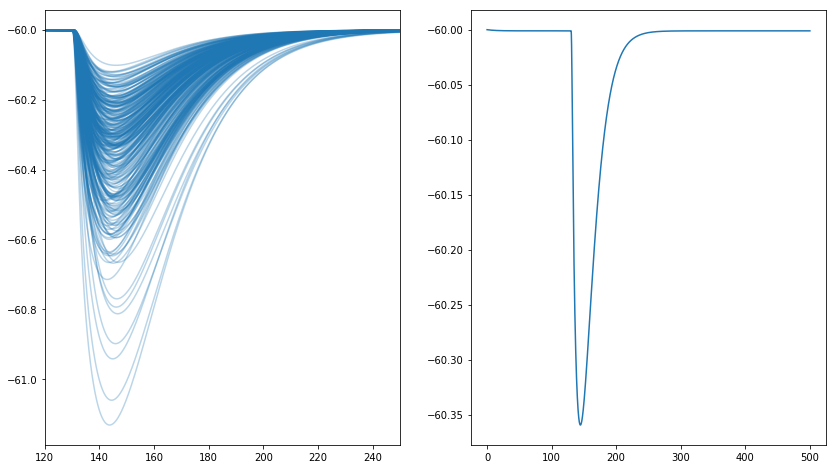

In [60]:
fig,ax = subplots(1,2,figsize=(14,8))
for i in range(300):
    ax[0].plot(trec,vtracsS1[:,i],'C0-',alpha=0.3)
ax[1].plot(trec,vtracsS1[:,:].mean(1),'-')
ax[0].set_xlim(120,250)

In [61]:
gtrA = gtrA0
gtrN = gtrN0
gtrG = gtrG0
res = simulateSet(model,spdata,tG = 500,ton = 50,toffset = 70,
                  t_stop = 500, EL = -70.0,btsr = ones(9)==1,
                  VDCC = VDCCa,dendrec=False,inhOutside = False)

vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = res

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in sqrt


In [62]:

#spdata['Rneck'] = Rn0*1e-3
#spdata['A2'] = A20*1.87

res = simulateSet(model,spdata,tG = -2,ton = 50,toffset = 70,
                  t_stop = 500, EL = -70.0,btsr = ones(9)==1,
                  VDCC = VDCCa,dendrec=False,inhOutside = False)

vavgD,mesD,vtracsD,vtracsDD,vtracsSD,CtracsD,me2,me3,_ = res


/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in sqrt


In [63]:
spdata.keys()

dict_keys(['#Sp', '#Bch', 'Dsb', 'Dss', 'd_interSp', 'Vtot', 'Vh', 'Ln', 'SA', 'nPSD', 'A1', 'A2', 'GPHN_SNR', 'DiS-EMchk', 'Lneck', 'maxDneck', 'minDneck', 'meanDneck', 'Rneck', 'Lhead', 'maxDhead', 'minDhead', 'meanDhead', 'Ah', 'Rhead', 'meanDneck_trunc70pc', 'L', 'D', 'AhA0'])

0.9389307880964621 0.987055707028276


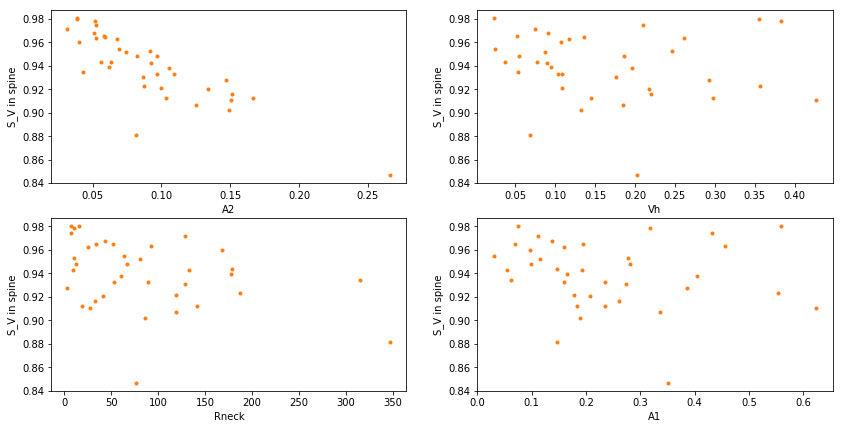

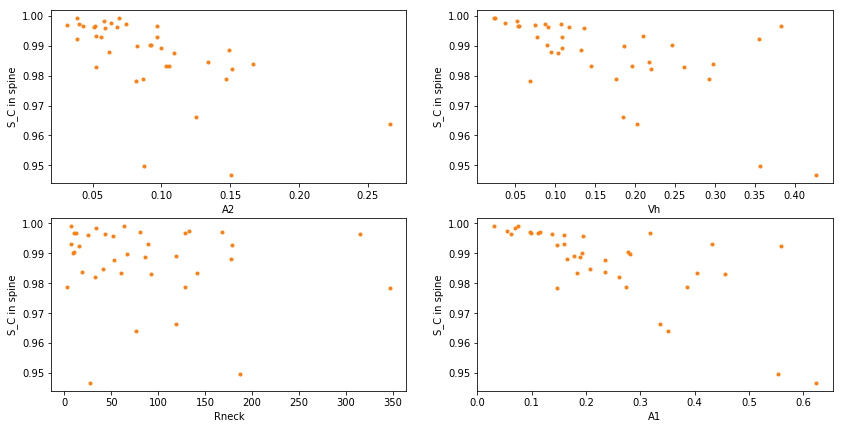

In [64]:
sel = spdata['A2']>0 
labels = ['A2','Rneck','Vh','A1']
fig,ax = subplots(2,2,figsize=(14,7))
for i in range(4):
    ax[i%2,i//2].plot(spdata[labels[i]][sel],mesD[sel,1]/mes[sel,1],'C1.')
    ax[i%2,i//2].set_xlabel(labels[i])
    ax[i%2,i//2].set_ylabel('S_V in spine')

fig,ax = subplots(2,2,figsize=(14,7))
for i in range(4):
    ax[i%2,i//2].plot(spdata[labels[i]][sel],mesD[sel,4]/mes[sel,4],'C1.')
    ax[i%2,i//2].set_xlabel(labels[i])
    ax[i%2,i//2].set_ylabel('S_C in spine')
      
print((mesD[sel,1]/mes[sel,1]).mean(),(mesD[sel,4]/mes[sel,4]).mean())

In [65]:
res = simulateSet(model,spdata,tG = -2,ton = 50,toffset = 70,
                  t_stop = 500, EL = -70.0,btsr = ones(9)==1,
                  VDCC = VDCCa,dendrec=False,inhOutside = True)

vavgO,mesO,vtracsO,vtracsDO,vtracsSO,CtracsO,me2,me3,_ = res

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in sqrt


0.9389307880964621 0.987055707028276
1.0 1.0


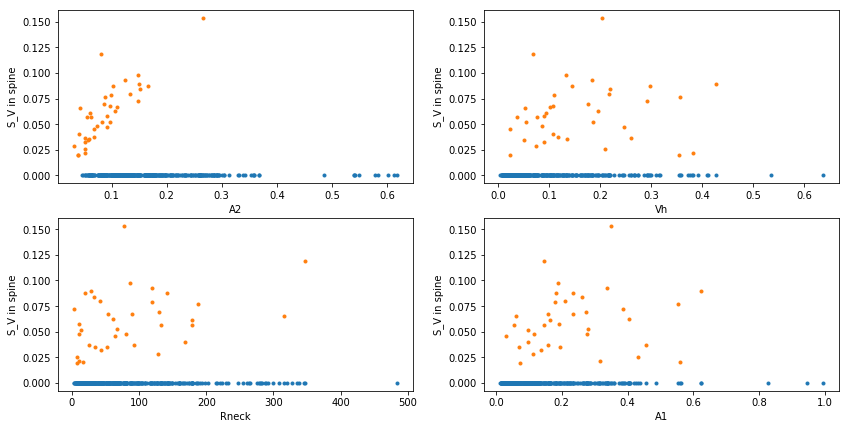

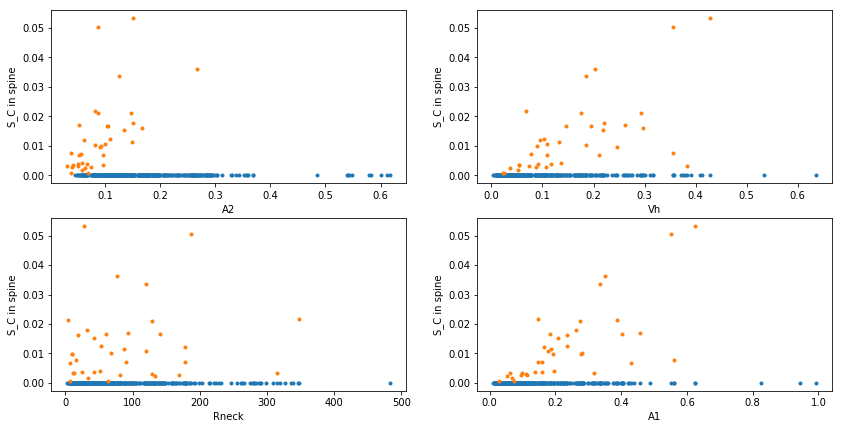

In [66]:
sel = spdata['A2']>0 
sel0 = spdata['A1']>0 

labels = ['A2','Rneck','Vh','A1']
fig,ax = subplots(2,2,figsize=(14,7))
for i in range(4):
    if labels[i] == 'A2':
        ax[i%2,i//2].plot(array(iPSDsh)[sel0],1-mesO[sel0,1]/mes[sel0,1],'.')
    else:
        ax[i%2,i//2].plot(spdata[labels[i]][sel0],1-mesO[sel0,1]/mes[sel0,1],'.')
    ax[i%2,i//2].plot(spdata[labels[i]][sel],1-mesD[sel,1]/mes[sel,1],'.')
    ax[i%2,i//2].set_xlabel(labels[i])
    ax[i%2,i//2].set_ylabel('S_V in spine')

fig,ax = subplots(2,2,figsize=(14,7))
for i in range(4):
    if labels[i] == 'A2':
        ax[i%2,i//2].plot(array(iPSDsh)[sel0],1-mesO[sel0,4]/mes[sel0,4],'.')
    else:
        ax[i%2,i//2].plot(spdata[labels[i]][sel0],1-mesO[sel0,4]/mes[sel0,4],'.')
        
    ax[i%2,i//2].plot(spdata[labels[i]][sel],1-mesD[sel,4]/mes[sel,4],'.')
    ax[i%2,i//2].set_xlabel(labels[i])
    ax[i%2,i//2].set_ylabel('S_C in spine')
      
print((mesD[sel,1]/mes[sel,1]).mean(),(mesD[sel,4]/mes[sel,4]).mean())
print((mesO[sel0,1]/mes[sel0,1]).mean(),(mesO[sel0,4]/mes[sel0,4]).mean())

In [ ]:
gtrN=gtrN0

In [ ]:
tFWHM = tools.get_FWHMtimes(vtracsS,-70)
ts,_,trise = tools.get_atimes(vtracsS+70,ton=2400)
tssp,_,_ = tools.get_atimes(vtracs+70,ton=2400)
#ts,_,trise = get_atimes(vtracsS+70,ton=2400)
t2080 = tools.get_p0p1times(vtracsS)#
t8020 = get_postp0p1times(vtracsS)#

#print(ts)
#h0 = hist(tFWHM,31)
#h1 = hist(ts[:,0],31,alpha=0.5)
h1 = hist(t2080,31,alpha=0.5)
h1 = hist(t8020/log(4),31,alpha=0.5)

t2080.mean(),t8020.mean()/log(4),ts[:,0].mean(),tssp.mean()

In [ ]:
gtrA = gtrA0*62.5/49
gtrN = gtrN0*0
VDCCn = VDCCa*0.02/.15

res = simulateSet(model,spdata,tG = td,ton = 50,toffset = 70,
                  t_stop = 500, EL = -70,btsr = ones(9)==1,
                  VDCC = VDCCn,dendrec=False)
vavg0,mes0,vtracs0,vtracsD,vtracsS,Ctracs,me2,me3,_ = res

gtrA = gtrA0*62.5/49
gtrN = gtrN0*15/3.24
td = 500
res = simulateSet(model,spdata,tG = td,ton = 50,toffset = 70,
                  t_stop = 500, EL = -70,btsr = ones(9)==1,
                  VDCC = VDCCn,dendrec=False)
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = res

In [ ]:
fig,ax = subplots(1,2,figsize=(14,8))
ax[0].plot(spdata['A1'],mes[:,4],'.')
ax[1].plot(spdata['A1'],mes0[:,4]/mes[:,4],'.')
print(mes[:,4].mean(),(mes0[:,4]/mes[:,4]).mean())
fig,ax = subplots(1,2,figsize=(14,8))
ax[0].plot(spdata['A1'],mes[:,1],'.')
ax[1].plot(spdata['A1'],mes0[:,1],'.')
print(mes[:,4].mean(),(mes0[:,4]/mes[:,4]).mean())

In [ ]:
spdata['A1'].mean()*gtrN*1e3,spdata['A1'].mean()*gtrA0*1e3

In [ ]:
mes.std(axis=0)/mes.mean(axspis=0)

In [ ]:
plot(spdata['Rneck'],(mes[:,1]-mes[:,2])/mes[:,1],'.')
sel = spdata['nPSD']==2.0
plot(spdata['Rneck'][sel],(mes[sel,1]-mes[sel,2])/mes[sel,1],'.')

In [ ]:
gtrA = gtrAp
gtrN = gtrNp
AMPA.tau2 = 1.3
td = 500
res = simulateSet(model,spdata,tG = td,ton = 50,toffset = 70,
                  t_stop = 500, EL = -70,btsr = ones(9)==1,
                  VDCC = VDCCa,dendrec=False)
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = res


In [ ]:
plot(spdata['A1'],-mes[:,-3]*1000,'.')
sel = spdata['nPSD']==2.0
plot(spdata['A1'][sel],-mes[sel,-3]*1000,'.')
i = getintp(-mes[:,-3]*1000,0.68)
print('Spines <uEPSC> = %.2f, (med,cf int 0.68) = (%.2f,%.2f,%.2f)' % (-mes[:,-3].mean()*1e3,i[0],i[1],i[2]))
i = getintp(-mes[sel,-3]*1000,0.68)
print('DiS <uEPSC> = %.2f, (med,cf int 0.68) = (%.2f,%.2f,%.2f)' % (-mes[sel,-3].mean()*1e3,i[0],i[1],i[2]))

i = getintp(mes[~sel,3],0.68)
print('SiS <uEPSP> = %.2f, (med,cf int 0.68) = (%.2f,%.2f,%.2f)' % (mes[:,3].mean(),i[0],i[1],i[2]))
print('CV and conductance', mes[:,3].std()/mes[:,3].mean(), spdata['A1'].mean()*gtrA*1e3)

In [ ]:
plot(spdata['Vh'],-mes[:,-3]*1000,'.')